In [1]:
import torch
from torch import nn

import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

import IPython.display as idp

import matplotlib.pyplot as plt
import numpy as np


In [2]:
visualize=False
# Feature gate: Overtones Splits
fg_generic_bands = True

### 1) Input and preparation

In [3]:
# load audio

sample_rate = 44100 # 

def show_idp_audio(waveform):
    n = 14
    return idp.display(idp.Audio(waveform[(3 * n) * sample_rate:(3 * (n + 1)) * sample_rate], rate=sample_rate))

def load_audio(path, visualize=False):
    waveform, sr = torchaudio.load(path)
    # Convert everthing to mono channel for simplicity
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0)
        # waveform is now a vector 
    # Resample everything to 44.1khz for simplicity
    resampler = T.Resample(sr, sample_rate, dtype=waveform.dtype)
    waveform = resampler(waveform)
    
    if visualize:
        # samplerate = 1/t
        # display the first 3 seconds
        show_idp_audio(waveform)
    
    return waveform

if visualize:
    sample_waveform = load_audio("mixture.wav", visualize=True)

    sample_waveform.size()

In [4]:
def rms_normalize(waveform, target_rms):
    current_rms = torch.sqrt(torch.mean(waveform**2))
    gain_factor = target_rms / (current_rms + 1e-10)
    normalized_waveform = waveform * gain_factor
    return normalized_waveform, gain_factor

def rms_denormalize(normalized_waveform, gain_factor):
    inverse_gain = 1 / gain_factor
    reversed_waveform = normalized_waveform * inverse_gain
    return reversed_waveform

def peak_normalize(waveform, target_peak):
    peak_value = torch.max(torch.abs(waveform))
    peak_gain_factor = target_peak / (peak_value + 1e-10)
    normalized_waveform = waveform * peak_gain_factor
    return normalized_waveform, peak_gain_factor

def peak_denormalize(normalized_waveform, peak_gain_factor):
    inverse_peak_gain = 1 / peak_gain_factor
    reversed_waveform = normalized_waveform * inverse_peak_gain
    return reversed_waveform

def inspect_waveform(waveform):
    transform = T.Loudness(sample_rate)
    return f"LKFS:{transform(waveform.unsqueeze(0))} max: {waveform.max()} min: {waveform.min()} avg: {waveform.mean()}"

def normalize_waveform(waveform, visualize=False):
    """ rms -> peak """
    # target rms can be anything. the important part here
    # is to be constant for all kind of songs

    if visualize:
        print("original: " + inspect_waveform(waveform))
        show_idp_audio(waveform)

    normalized_waveform, gain_factor = rms_normalize(waveform, target_rms=0.1)
    
    if visualize:
        print("rms_normalize: " + inspect_waveform(normalized_waveform))
        show_idp_audio(normalized_waveform)

    # setting target peak to 1.0 forces the values between -1.0 < y < 1.0
    normalized_waveform, peak_gain_factor = peak_normalize(normalized_waveform, target_peak=0.1)
    
    if visualize:
        print("peak_normalize: " + inspect_waveform(normalized_waveform))
        show_idp_audio(normalized_waveform)
    
    return normalized_waveform, gain_factor, peak_gain_factor

def de_normalize_waveform(waveform, gain_factor, peak_gain_factor, visualize=False):
    if visualize:
        print("de_normalize_waveform: " + inspect_waveform(waveform))
        show_idp_audio(waveform)
    
    waveform = peak_denormalize(waveform, peak_gain_factor)
    
    if visualize:
        print("peak_denormalize: " + inspect_waveform(waveform))
        show_idp_audio(waveform)
    waveform = rms_denormalize(waveform, gain_factor)
    
    if visualize:
        print("rms_denormalize: " + inspect_waveform(waveform))
        show_idp_audio(waveform)
    
    return waveform

if visualize:
    normal_waveform, gain_factor, peak_gain_factor = normalize_waveform(sample_waveform, visualize=True)
    _ = de_normalize_waveform(normal_waveform, gain_factor, peak_gain_factor, visualize=True)

In [5]:
chunk_size_in_seconds = 1
chunk_size = chunk_size_in_seconds * sample_rate

def split(waveform, visualize=False):
    # we have a vector by length n and we want to split it to even chunks by length of
    # chunk_size
    padding_length = (chunk_size - waveform.shape[0] % chunk_size) % chunk_size
    waveform = nn.functional.pad(waveform, (0, padding_length), 'constant', 0)
    # -1 means automatically infer based on other dims
    chunked_waveform = waveform.view(-1, chunk_size)
    
    if visualize:
        fig = plt.figure(constrained_layout=True, figsize=(16, 4))
        subfigs = fig.subfigures(2, 1).flat
        
        # first 3 chunk_size of waveform
        w = waveform[:3 * chunk_size].detach().numpy()
        ylim = [w.max() * 1.1, w.min() * 1.1]
        def time_axis(start, duration):
            return torch.arange(start * sample_rate, (duration + start) * sample_rate) / sample_rate
        axes = subfigs[0].subplots(1, 1)
        axes.plot(time_axis(0, 3), w, linewidth=0.3)
        axes.set_xlabel("time [s] for first 3 seconds")
        axes.set_ylim(ylim)
        
        # first 4 chunks + last chunk
        axes = subfigs[1].subplots(1, 5)
        for i, chunk in enumerate([0, 1, 3, 4, chunked_waveform.shape[0] - 1]): 
            axes[i].plot(time_axis(0, chunk_size_in_seconds), chunked_waveform[chunk], linewidth=0.3)
            axes[i].set_title(f"chunk {chunk}")
            axes[i].set_ylim(ylim)
        
    return chunked_waveform, padding_length

def merge(chunks, padding_length):
    merged_waveform = torch.cat([torch.flatten(x) for x in chunks])
    return merged_waveform[:-padding_length]

if visualize:
    sample_waveform_chunks, padding_length = split(normal_waveform, visualize=True)

    assert sample_waveform_chunks.shape[1] == chunk_size

    sample_merged = merge(sample_waveform_chunks, padding_length)

    assert sample_merged.shape == normal_waveform.shape
    assert torch.all(sample_merged == normal_waveform)

In [6]:
n_fft = 2048
win_length = n_fft
hop_length = win_length // 4


def visualize_spectogram(chunk, chunk_stft, title='Spectogram'):
    import librosa
    fig, axis = plt.subplots(2, 1, figsize=(16, 5))
    noverlap = win_length - hop_length
    axis[0].imshow(librosa.power_to_db(chunk_stft.abs().detach().numpy() ** 2), origin="lower", aspect="auto", interpolation="nearest")
    axis[0].set_yscale("symlog")
    axis[0].set_title(title)
    if chunk is not None:
        axis[1].plot(chunk, linewidth=0.5)
        axis[1].grid(True)
        axis[1].set_xlim([0, len(chunk)])

def to_spectogram():
    transform_spectogram = T.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length,\
                                         window_fn=torch.hamming_window, power=None)
    def inner(chunk, visualize=False, title=''):
        chunk_stft = transform_spectogram(chunk)
        if visualize:
            visualize_spectogram(chunk, chunk_stft, title)

        return chunk_stft
    return inner

if visualize:
    print(sample_waveform_chunks[1].shape)
    chunk_stft = to_spectogram()(sample_waveform_chunks[1], visualize=True)
    chunk_stft.shape

In [7]:
class Vis:
    def visualize(self, input):
        from torchview import draw_graph
        y = self(input)
        x = draw_graph(self, input_data=input, device='meta', roll=True)
        print(f"--{input.shape}-->f(x)--{y.shape}-->")
        file = x.visual_graph.render(self._get_name())
        display(idp.FileLink("./" + file))

40


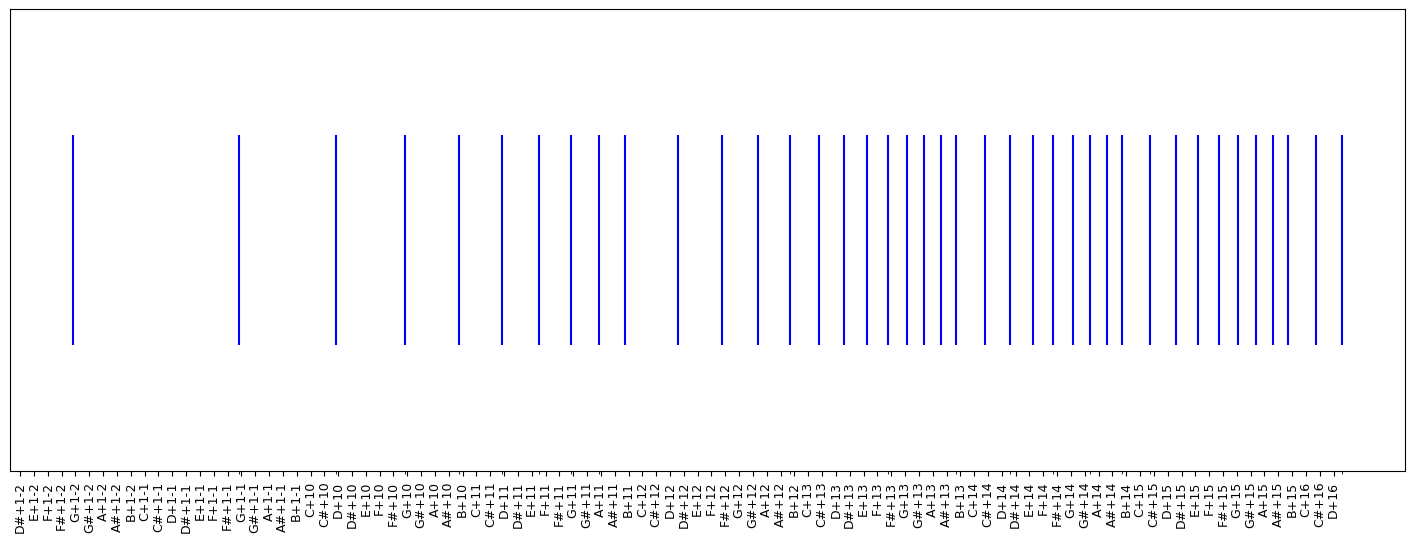

41


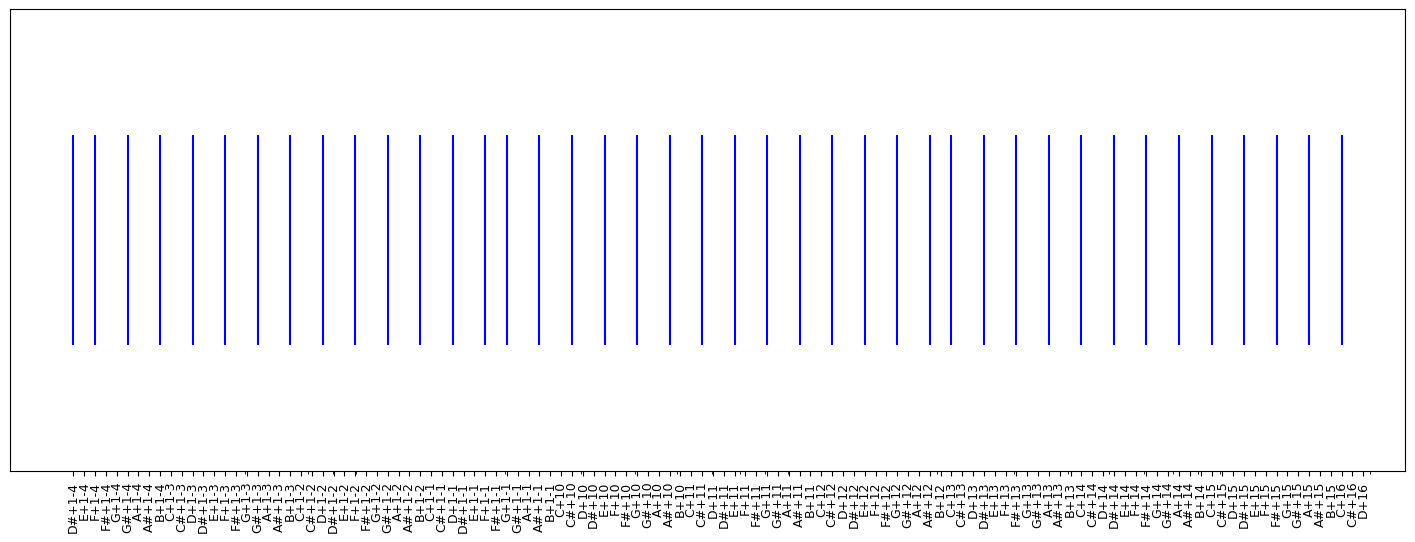

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import numpy as np

def get_microtone_name(semitones_from_A4, divisions_per_octave):
    notes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    microtone_index = int((semitones_from_A4 + 9) * divisions_per_octave / 12) % divisions_per_octave
    octave = int((semitones_from_A4 + 9) // 12)
    note_index = microtone_index // (divisions_per_octave // 12)
    microtone_suffix = f"+{microtone_index % (divisions_per_octave // 12)}"
    return notes[note_index] + (microtone_suffix if microtone_suffix != "+0" else "") + str(octave)

def microtonal_notes(divisions_per_octave):
    A4_freq = 440.0
    min_freq = 20.0
    max_freq = 20000.0
    notes = []
    freqs = []
    current_freq = min_freq
    while current_freq <= max_freq:
        semitones_from_A4 = 12 * np.log2(current_freq / A4_freq)
        nearest_microtone = round(semitones_from_A4 * divisions_per_octave / 12)
        nearest_freq = A4_freq * (2 ** (nearest_microtone / divisions_per_octave))

        # Check if the frequency is a microtonal (not a standard semitone)
        if nearest_microtone % (divisions_per_octave // 12) != 0:
            note_name = get_microtone_name(nearest_microtone / (divisions_per_octave / 12), divisions_per_octave)
            notes.append(note_name)
            freqs.append(nearest_freq)

        # Move to the next microtone
        current_freq = A4_freq * (2 ** ((nearest_microtone + 1) / divisions_per_octave))
    return (notes, freqs)

def plot_custom_labeled_attention_distribution(splits):
    start_freq = 0
    events = []
    for end_freq, step_size in splits:
        while start_freq < end_freq:
            start_freq += step_size
            events.append(start_freq)

    notes, positions = microtonal_notes(24)
    print(len(events))

    # Plotting
    plt.figure(figsize=(18, 6))
    plt.xscale("log")
    plt.yticks([])
    plt.xticks(positions, notes, rotation=90, fontsize=9)
    plt.eventplot(events, orientation='horizontal', colors='b')
    

    plt.show()

plot_custom_labeled_attention_distribution(splits_v7)

def evenly_skip_elements(input_list, k):
    """
    Reduce the size of the input list to 'k' by skipping elements evenly.

    :param input_list: The original list.
    :param k: The desired size of the new list, must be smaller or equal to the size of input_list.
    :return: A new list of size 'k'.
    """
    if k > len(input_list):
        raise ValueError("k must be smaller or equal to the size of the input list")

    # Calculate the step for even skipping
    step = len(input_list) / k

    # Generate the new list
    new_list = [input_list[int(i * step)] for i in range(k)]

    return new_list

def create_evenly_distributed_splits(num_splits):
    _, freqs = microtonal_notes(24)
    splits = []
    last_freq = 0
    for freq in evenly_skip_elements(freqs, num_splits):
        splits.append((freq, freq - last_freq))
        last_freq = freq
    return splits
    

splits_generic = create_evenly_distributed_splits(41)
plot_custom_labeled_attention_distribution(splits_generic)

In [9]:
# Numbers are exctracted from the paper
splits_v7 = [
   # below 1kh, bandwidth 100hz
   (1000, 100),
   # above 1kh and below 4khz, bandwidth 250hz
   (4000, 250),
   (8000, 500),
   (16000, 1000),
   (20000, 2000),
]

print(splits_generic)

temporal_dim = int(np.ceil(chunk_size / T.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length).hop_length))
feature_dim = 128 // 4

# Module 1
class BandSplit(nn.Module, Vis):
    
    def __init__(self, splits=splits_generic, fully_connected_out=feature_dim):
        super(BandSplit, self).__init__()
        
        
        #### Make splits
        # convert fft to freq
        freqs = sample_rate * torch.fft.fftfreq(n_fft)[:n_fft // 2 + 1]
        freqs[-1] = sample_rate // 2
        indices = []
        start_freq, start_index = 0, 0
        for end_freq, step in splits:
            bands = torch.arange(start_freq + step, end_freq + step, step)
            start_freq = end_freq
            for band in bands:
                end_index = freqs[freqs < band].shape[0]
                if end_index != start_index:
                    indices.append((start_index, end_index))
                start_index = end_index
        indices.append((start_index, freqs.shape[0]))
        self.band_indices = indices
        print(self.band_indices)
        self.fully_connected_out = fully_connected_out
        
        self.layer_norms = nn.ModuleList([
            # * 2 is for added dim of view_as_real
            nn.LayerNorm([(band_end - band_start) * 2, temporal_dim])
            for band_start, band_end in self.band_indices
        ])
        
        self.layer_fcs =  nn.ModuleList([
            # * 2 is for added dim of view_as_real
            nn.Linear((band_end - band_start) * 2, fully_connected_out)
            for band_start, band_end in self.band_indices
        ])

    def forward(self, chunk_ftt):
        batch_size = chunk_ftt.size(0)
        stack = []
        # TODO: can i vectorize this loop?
        for i, (band_start, band_end) in enumerate(self.band_indices):
            band = chunk_ftt[:, band_start:band_end, :]
            # band is shape of (B, F, T)
            band = torch.view_as_real(band) # (B, F, T, 2)
            # convert to (B, 2, F, T) to be able to feed it to the norm
            band = band.permute(0, 3, 1, 2)
            
            # norm is (..., F, T) and fc is (Fxfully_connected_out)
            # we should make norm (..., T, F) in order to feed it to the fc
            band = band.reshape(batch_size, -1, band.size(-1)) # -1 = T
            norm = self.layer_norms[i](band)
            
            norm = norm.transpose(-1, -2).contiguous()
            fc_y = self.layer_fcs[i](norm)
            
            stack.append(fc_y)
        return torch.stack(stack, dim=1)

if visualize:
    bandsplit_layer = BandSplit()
    bandsplit_y = bandsplit_layer(chunk_stft.unsqueeze(0))
    bandsplit_layer.visualize(chunk_stft.unsqueeze(0))

[(20.015231264080082, 20.015231264080082), (22.466337482065118, 2.4511062179850356), (26.717128381724155, 4.250790899659037), (31.772199163987512, 5.055070782263357), (37.783725305097455, 6.011526141109943), (44.93267496413025, 7.148949659032795), (53.43425676344833, 8.501581799318082), (63.544398327975024, 10.110141564526693), (75.56745061019491, 12.023052282219886), (89.8653499282605, 14.29789931806559), (106.86851352689666, 17.003163598636164), (127.08879665595002, 20.220283129053357), (151.1349012203898, 24.046104564439773), (179.73069985652097, 28.59579863613118), (201.74088950502767, 22.010189648506696), (239.91170118635668, 38.17081168132901), (285.30470202322215, 45.39300083686547), (339.28638158974695, 53.981679566524804), (403.48177901005533, 64.19539742030838), (479.82340237271336, 76.34162336265803), (570.6094040464443, 90.78600167373094), (678.5727631794939, 107.96335913304961), (806.9635580201107, 128.39079484061676), (959.6468047454267, 152.68324672531605), (1141.2188080

In [10]:
# Module 2

class RNN(nn.Module):
    def __init__(self, input_dim_size):
        super(RNN, self).__init__()
        self.input_dim_size = input_dim_size
        # paper specified group norm
        self.norm = nn.ModuleList([nn.GroupNorm(self.input_dim_size, self.input_dim_size) for _ in range(2)])
        self.blstm = nn.ModuleList([nn.LSTM(self.input_dim_size, self.input_dim_size, bidirectional=True, batch_first=True) for _ in range(2)])
        self.fc = nn.ModuleList([nn.Linear(self.input_dim_size * 2, self.input_dim_size) for _ in range(2)])
    
    def forward(self, x):
        # input is b, bands(K), temporal_dim(t), input_dim_size
        
        
        # First loops converts the shape to [B, T, K, N]
        # and the second loop converts it back to [B, K, T, N]
        for i in range(2):
            B, K, T, N = x.shape
            out = x.view(B * K, T, N)
            out = self.norm[i](out.transpose(-1, -2)).transpose(-1, -2)
            out = self.blstm[i](out)[0]
            out = self.fc[i](out)
            x = out.view(B, K, T, N) + x
            x = x.permute(0, 2, 1, 3).contiguous()
        
        return x

num_blstm_layers=24 // 2

class BandSequence(nn.Module, Vis):
    
    def __init__(self, input_dim_size, num_layers=num_blstm_layers):
        super(BandSequence, self).__init__()
        self.rnns = nn.Sequential(*[RNN(input_dim_size=input_dim_size) for _ in range(num_layers)])
        
    def forward(self, x):
        # (bands, temporal_dim, fc_out)
        return self.rnns(x)

if visualize:
    bandsequence_layer = BandSequence(input_dim_size=bandsplit_layer.fully_connected_out)
    bandsequence_y = bandsequence_layer(bandsplit_y)
    bandsequence_layer.visualize(bandsplit_y)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

class MaskEstimation(nn.Module, Vis):
    def __init__(self, band_indices, fully_connected_out):
        super(MaskEstimation, self).__init__()
        
        max_indice_diff = max([e - s for s, e in band_indices])
        num_hiddens = lambda e, s: 3 * (max_indice_diff - (e - s) + 1)
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm([temporal_dim, fully_connected_out]),
                nn.Linear(fully_connected_out, num_hiddens(e, s)),
                nn.Tanh(),
                # double the output dim to use in GLU
                # the extra *2 is for returning as complex
                nn.Linear(num_hiddens(e, s), (e - s) * 2 * 2),
                nn.GLU()
            )
            for s, e in band_indices
        ])
        
    def forward(self, x):
        # (b, k, temporal_dim, fc_out)
        parts = []
        for i in range(x.shape[1]):
            y = self.layers[i](x[:, i]).contiguous()
            B, T, F = y.shape
            y = y.permute(0, 2, 1).contiguous() # B F T
            # basically halve the freq dim and use it for phasee
            y = y.view(B, 2, F // 2, T) # (B, 2, F, T)
            y = y.permute(0, 2, 3, 1) # (B, F, T, 2)
            y = torch.view_as_complex(y.contiguous())
            
            parts.append(y)
        
        # (b, f, t)
        return torch.cat(parts, dim=-2)

    
if visualize:   
    mask_layer = MaskEstimation(band_indices=bandsplit_layer.band_indices, fully_connected_out=bandsplit_layer.fully_connected_out)
    mask_y = mask_layer(bandsequence_y)
    mask_layer.visualize(bandsequence_y)

In [12]:
class BSRNN(nn.Module, Vis):
    
    def __init__(self):
        super(BSRNN, self).__init__()
        
        self.split = BandSplit()
        self.sequence = BandSequence(input_dim_size=self.split.fully_connected_out)
        self.mask = MaskEstimation(band_indices=self.split.band_indices, fully_connected_out=self.split.fully_connected_out)

    def forward(self, chunk_fft):
        
        mean = chunk_fft.mean(dim=(1, 2), keepdim=True)
        std = chunk_fft.std(dim=(1, 2), keepdim=True)
        chunk_fft = (chunk_fft - mean) / (std + 1e-5)
        
        y = self.split(chunk_fft)
        y = self.sequence(y)
        mask = self.mask(y)
        
        mask = mask * std + mean

        return mask

if visualize:
    bsrnn = BSRNN().cuda()
    bsrnn_y = bsrnn(chunk_stft.unsqueeze(0).cuda())
    bsrnn.visualize(chunk_stft.unsqueeze(0).cuda())

In [13]:

def from_spectogram():
    # We are using GriffinLim to ensure the output size
    transform_inv_spectogram = T.InverseSpectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length,\
                                                    window_fn=torch.hamming_window)

    def inner(chunk_stft, visualize=False):
        chunk = transform_inv_spectogram(chunk_stft)
    
        if visualize:
            visualize_spectogram(chunk.detach().numpy(), chunk_stft)

        return chunk
    return inner

if visualize:
    print(bsrnn_y.shape)
    masked_complex = chunk_stft * bsrnn_y[0].cpu()

    chunk_y = from_spectogram()(masked_complex, visualize=True)
    chunk_y.shape

In [14]:
if visualize and False:
    chunk_x = de_normalize_waveform(sample_waveform_chunks[1], gain_factor, peak_gain_factor)
    chunk_y = de_normalize_waveform(chunk_y, gain_factor, peak_gain_factor)

    print("In:")
    show_idp_audio(chunk_x)
    print("Out:")
    show_idp_audio(chunk_y.detach().numpy())
    print(chunk_y.shape)
    chunk_size

In [15]:
import gc
torch.cuda.empty_cache()
gc.collect()

37554

In [16]:
# Put Everything Together! audio in, audio out!


class MSSBandSplitRNN(nn.Module, Vis):
    def __init__(self):
        super(MSSBandSplitRNN, self).__init__()
        self.to_spectogram = to_spectogram()
        self.from_spectogram = from_spectogram()
        self.bsrnn = BSRNN()
        
    def forward(self, waveform):
        """ Waveform in -> Waveform out :) """
        
        # 1) normalize
        # 2) split
        # 3) feed to bsrnn
        # 4) convert spectogram to audio
        # 5) merge all splits
        # 6) de-normalize
        
        normal_waveform, gain_factor, peak_gain_factor = normalize_waveform(waveform)
        splits, padding_length = split(normal_waveform)
        masked_splits = [() for _ in range(len(splits))]
        for i, x_split in enumerate(splits):
            split_stft = self.to_spectogram(x_split)
            mask = self.bsrnn(split_stft.unsqueeze(0))[0]
            
            masked_complex = mask
            
            wave = self.from_spectogram(masked_complex)
            masked_splits[i] = wave
        
        masked_waveform = merge(masked_splits, padding_length)
        y = de_normalize_waveform(masked_waveform, gain_factor, peak_gain_factor)
        return y

if visualize:
    torch.set_default_device('cuda')
    with torch.no_grad():
        model = MSSBandSplitRNN()
        y = model(sample_waveform.cuda())


    print("In:")
    show_idp_audio(sample_waveform)
    print("Out:")
    show_idp_audio(y.cpu().detach().numpy())

# 2) Train

In [17]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mae_stft_real = nn.L1Loss()
        self.mae_stft_imag = nn.L1Loss()
        self.mae_inv_stft  = nn.L1Loss()
    
    def forward(self, pred_stft, target_stft,  pred_inv_stft, target_inv_stft):
        loss_r = self.mae_stft_real(pred_stft.real, target_stft.real)
        loss_i = self.mae_stft_imag(pred_stft.imag, target_stft.imag)
        loss_t = self.mae_inv_stft(pred_inv_stft, target_inv_stft)
        loss = loss_r + loss_i + loss_t
        return loss

def compute_usdr(pred, target, delta = 1e-7):
    if pred.shape[0] < target.shape[0]:
        padding = target.shape[0] - pred.shape[0]
        pred = torch.nn.functional.pad(pred, (0, padding), "constant", 0)
    num = torch.sum(torch.square(target))
    den = torch.sum(torch.square(target - pred))
    num += delta
    den += delta
    usdr = 10 * torch.log10(num / den)
    return usdr.mean()

if visualize and False:
    torch.set_default_device('cpu')
    target_wf = load_audio("drums.wav")
    normal_target_wf, gain_factor, peak_gain_factor = normalize_waveform(target_wf)
    target_wf_chunks, padding_length = split(normal_target_wf)
    stft = to_spectogram()
    inv_stft = from_spectogram()
    print("target:")
    show_idp_audio(target_wf_chunks[1])
    target_stft = stft(target_wf_chunks[1], visualize=True, title="Target")
    print("input:")
    show_idp_audio(sample_waveform_chunks[1])
    sample_stft = stft(sample_waveform_chunks[1], visualize=True, title="Input")

    # x * mask = target_stft / x
    # f(x) = stft - 

    mask_stft = target_stft / sample_stft
    visualize_spectogram(inv_stft(mask_stft), mask_stft, title="Mask stft")
    print("Mask:")
    show_idp_audio(inv_stft(mask_stft))
    target_y = sample_stft * mask_stft
    print("Target_y: ")
    show_idp_audio(inv_stft(target_y))
    visualize_spectogram(inv_stft(target_y), target_y, title="Target_y stft calc")


    loss_fn = CustomLoss()
    loss = loss_fn.forward(target_y, target_stft, inv_stft(target_y), inv_stft(target_stft))
    print(f"loss: {loss}")

In [18]:
import os
import random
import math

# Dataloader

torch.set_default_device('cpu')

class Dataset(torch.utils.data.IterableDataset):
    def __init__(self, dir_="/home/sahand/BandSplit-RNN/musdb18hq/", validation=False):
        super(Dataset, self).__init__()
        path = dir_ + ("test" if validation else "train")
        print(path)
        self.files = [entry for entry in os.scandir(path) if entry.is_dir()]
        random.shuffle(self.files)
    
    def iterator(self):
        torch.set_default_device('cpu')
        to_stft = to_spectogram()
        for i in range(self.start_index, self.end_index):
            d = self.files[i]
            mixture = f"{d.path}/mixture.wav"
            target = f"{d.path}/drums.wav"

            normal_mix, _, _ = normalize_waveform(load_audio(mixture))
            normal_target, _, _ = normalize_waveform(load_audio(target))

            normal_mix, _ = split(normal_mix)
            normal_target, _ = split(normal_target)

            for mix, target in zip(normal_mix, normal_target):
                mix_stft = to_stft(mix)
                target_stft = to_stft(target)
                # Accumulate STFTs in the batch
                yield (mix_stft, target_stft)

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is not None:
            total_files = len(self.files)
            per_worker = int(math.ceil(total_files / float(worker_info.num_workers)))
            self.start_index = worker_info.id * per_worker
            self.end_index = min(self.start_index + per_worker, total_files)
        else:
            self.start_index = 0
            self.end_index = len(self.files)

        return iter(self.iterator())

In [19]:
torch.cuda.empty_cache()
gc.collect()

0

In [24]:
batch_size=95
clip_grad_norm=5

device = torch.device("cuda")

train_loader = torch.utils.data.DataLoader(Dataset(validation=False), num_workers=1, 
                                          batch_size=batch_size, drop_last=True,
                                          prefetch_factor=4,
                                          persistent_workers=True)
val_loader   = torch.utils.data.DataLoader(Dataset(validation=True), num_workers=1, 
                                          batch_size=batch_size, drop_last=True,
                                          prefetch_factor=4,
                                          persistent_workers=True)


model = BSRNN().to('cuda')
# model = torch.load("./drums-reversed-mask/bsrnn-102-0.031533900648355484.pt")
import datetime

name = f"generic-splits"
prefix=f"./train-logs/{name}-{datetime.datetime.now()}"
if not os.path.exists(name):
    os.makedirs(name)

/home/sahand/BandSplit-RNN/musdb18hq/train
/home/sahand/BandSplit-RNN/musdb18hq/test
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 8), (8, 9), (9, 10), (10, 12), (12, 14), (14, 16), (16, 19), (19, 23), (23, 27), (27, 32), (32, 38), (38, 45), (45, 53), (53, 64), (64, 75), (75, 90), (90, 101), (101, 119), (119, 142), (142, 169), (169, 201), (201, 238), (238, 283), (283, 337), (337, 401), (401, 464), (464, 476), (476, 566), (566, 674), (674, 801), (801, 928), (928, 1025)]


In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

2098025

In [26]:
import torch
from torch import nn
from torchvision.transforms import Compose, Normalize, ToTensor

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, Checkpoint, DiskSaver, global_step_from_engine
from ignite.contrib.handlers import TensorboardLogger, global_step_from_engine, ProgressBar, TensorboardLogger

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = CustomLoss()

torch.set_default_device('cuda')
inv_stft_gpu = from_spectogram()

def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    mix_stft, mask_stft = batch
    mix_stft, mask_stft = mix_stft.to('cuda'), mask_stft.to('cuda')
    y_mask = model(mix_stft)
    inv_y_mask = inv_stft_gpu(y_mask)
    inv_mask_stft = inv_stft_gpu(mask_stft)
    loss = loss_fn(y_mask, mask_stft, inv_y_mask, inv_mask_stft)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
    optimizer.step()
    
    usdr_value = compute_usdr(inv_y_mask, inv_mask_stft).item()
    return {'loss': loss.item(), 'usdr': usdr_value}

# Evaluation Step
# def evaluate_step(engine, batch):
#     model.eval()
#     with torch.no_grad():
#         mix_stft, mask_stft = batch
#         mix_stft, mask_stft = mix_stft.to('cuda'), mask_stft.to('cuda')
#         y_mask = model(mix_stft)
#         inv_y_mask = inv_stft_gpu(y_mask)
#         inv_mask_stft = inv_stft_gpu(mask_stft)
#         return y_mask, mask_stft, inv_y_mask, inv_mask_stft


trainer = Engine(train_step)
# evaluator = Engine(evaluate_step)

running_avg_usdr = RunningAverage(output_transform=lambda x: x['usdr'])
running_avg_usdr.attach(trainer, 'running_avg_usdr')
running_avg_loss = RunningAverage(output_transform=lambda x: x['loss'])
running_avg_loss.attach(trainer, 'running_avg_loss')

tb_logger = TensorboardLogger(log_dir=f"{prefix}/tb")
tb_logger.attach_output_handler(
    trainer,
    event_name=Events.ITERATION_COMPLETED,
    tag="training",
    output_transform=lambda x: {"running_avg_loss": trainer.state.metrics['running_avg_loss'], 
                                "running_avg_usdr": trainer.state.metrics['running_avg_usdr']}
)


# Model Checkpointing
to_save = {
    'trainer': trainer,
    'model': model,
    'optimizer': optimizer,
    'running_avg_usdr': running_avg_usdr,
    'running_avg_loss': running_avg_loss
}
checkpoint_handler = Checkpoint(to_save, DiskSaver(f'{prefix}/models', create_dir=True), n_saved=10, global_step_transform=global_step_from_engine(trainer))

trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoint_handler)

# Resume Training
checkpoint_fp = 'checkpoints/checkpoint.ckpt'
if os.path.isfile(checkpoint_fp):
    checkpoint = torch.load(checkpoint_fp)
    Checkpoint.load_objects(to_load=to_save, checkpoint=checkpoint)

# @trainer.on(Events.EPOCH_COMPLETED)
# def run_evaluation(engine):
#     evaluator.run(val_loader)

# @evaluator.on(Events.EPOCH_COMPLETED)
# def log_evaluation_results(engine):
#     metrics = engine.state.metrics
#     avg_usdr = metrics['usdr']
#     print(f"Validation Results - Epoch: {engine.state.epoch} Avg USDR: {avg_usdr:.2f}")
#     tb_logger.writer.add_scalar("validation/usdr", avg_usdr, engine.state.epoch)

# Progress Bar
pbar = ProgressBar(persist=True)
pbar.attach(trainer, metric_names=['running_avg_loss', 'running_avg_usdr'])

# Run Training
trainer.run(train_loader, max_epochs=500)

[1/?]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

[1/241]   0%|           [00:00<?]

Engine run is terminating due to exception: 


KeyboardInterrupt: 

In [ ]:
model

In [ ]:
torch.set_default_device('cuda')
m = MSSBandSplitRNN()
model.eval()
m.bsrnn = model
mixture_wav = load_audio("mixture.wav")
target_wav = load_audio("drums.wav")
with torch.no_grad():
    y = m(mixture_wav.cuda())
show_idp_audio(mixture_wav)
show_idp_audio(y.cpu().detach().numpy())
show_idp_audio(target_wav)


In [ ]:


torch.set_default_device('cuda')
import glob
models = list(glob.glob("*.pt"))
models = sorted(models, key=lambda x: int(x.split("-")[1]))
mixture_wav = load_audio("mixture.wav")
target_wav = load_audio("drums.wav")
print("mixture:")
show_idp_audio(mixture_wav)
print("target:")
show_idp_audio(target_wav)

dw = None
for i, model_path in enumerate(models):
    if i % 5 != 0:
        continue
    model_bsrnn = torch.load(model_path, map_location="cuda")
    m = MSSBandSplitRNN()
    m.bsrnn = model_bsrnn
    w = torch.cat([t.view(-1) for t in list(m.parameters())])
    if dw is None:
        dw = nn.L1Loss()(torch.zeros_like(w), w)
    else:
        dw = nn.L1Loss()(dw, w)
    with torch.no_grad():
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            y = m(mixture_wav.cuda())
        usdr = compute_usdr(y, target_wav.cuda())
        print(f"{model_path} △w={dw} usdr={usdr}: ")
        
        show_idp_audio(y.cpu().detach().numpy())
